# Import OSMNX and stuff

### OSRM notes:
```
cd ~/Documents/work/osrm/
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-hampshire-latest.osm.pbf
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-partition /data/new-hampshire-latest.osrm
docker run -t -v $(pwd):/data osrm/osrm-backend osrm-customize /data/new-hampshire-latest.osrm
docker run -t -i -p 5000:5000 -v $(pwd):/data osrm/osrm-backend osrm-routed --algorithm mld /data/new-hampshire-latest.osrm
```

In [124]:
import osmnx as ox

In [125]:
_,origin_point = ox.graph_from_address('2700 Broadway, New York City, New York', simplify=False, clean_periphery=False,
                                     retain_all=True, distance=50, network_type='all', return_coords=True)
home = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive')

In [253]:
home, origin_point = ox.graph_from_address('42 Wolf Rd, Lebanon, NH 03766, USA', 
                                           distance=6000, network_type='drive', return_coords=True, )

In [126]:
# The Red Arrow Diner:
home, origin_point = ox.graph_from_address('61 Lowell St, Manchester, NH 03101, USA', 
                                           distance=3000, network_type='drive', return_coords=True, )

4459

## How's it look?

In [255]:
origin_point

(43.6616276457689, -72.2504771492033)

In [256]:
ox.get_nearest_node(home, origin_point, return_dist=True)

(194823742, 81.678188780511249)

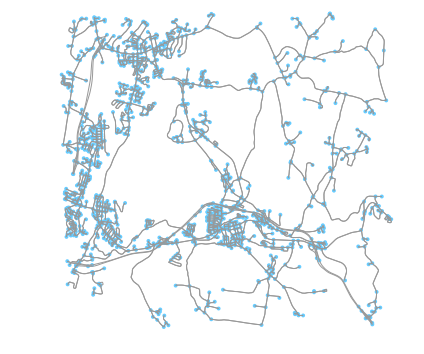

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [257]:
G = home.copy()
# G = nyc.copy()
# G = sf.copy()

center_node = ox.get_nearest_node(G, origin_point)
G = ox.project_graph(G)
fig, ax = ox.plot_graph(G)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10)
fig.show()

In [258]:
len(G)

1489

### COOOOOOL.

### initialize edge traffic to 1, source node traffic to 1:

In [259]:
for u, v, k, data in G.edges(data=True, keys=True):
    data['through_traffic'] = 1
    
for node, data in G.nodes(data=True):
    data['transit_time'] = 0 # np.nan
    data['calculated'] = False

## This does routing

In [260]:
import requests
import time

In [261]:
def osrm(origin_node, center_node, mode='driving'):
    start = '%f,%f' % (G.node[origin_node]['lon'],G.node[origin_node]['lat'])
    end = '%f,%f' % (G.node[center_node]['lon'],G.node[center_node]['lat'])
    
    query = 'http://localhost:5000/route/v1/%s/%s;%s?steps=true&annotations=true' % (mode,start,end)
    r = requests.get(query)

    route = r.json()['routes'][0]['legs'][0]['annotation']['nodes']
    transit_time = r.json()['routes'][0]['duration']
    
    return route,transit_time,r

# Run it on the whole graph!

In [262]:
from tqdm import tqdm
import networkx as nx

In [263]:
# for that route, for every edge on the route, increment the through-traffic 
#  count by the source traffic coming from the origin node..
def increment_edges(route, G, missing_edges):
    if len(route) > 0:
        for i0, i1 in zip(route[:-1], route[1:]):
            try:
                G.edges[i0,i1,0]['through_traffic'] += 1 # new way
            except KeyError:
                missing_edges.update((i0, i1))
                continue

        G.node[route[0]]['calculated'] = True
        increment_edges(route[1:], G, missing_edges)

In [270]:
# For every node in the map... new way
missing_edges = set([])
missing_nodes = set([])

for origin_node in tqdm(G.nodes()):
    if not G.node[origin_node]['calculated']:
        route,transit_time,r = osrm(origin_node, center_node, mode='driving')
        route = [node for node in route if node in list(G)]

        increment_edges(route, G, missing_edges)

100%|██████████| 1489/1489 [00:44<00:00, 33.19it/s]


In [271]:
len(missing_edges)

10

# Get transit times

In [272]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
end = '%s,%s' % (origin_point[1],origin_point[0])
starts = ['%s,%s' % (data['lon'],data['lat']) for n,data in G.node(data=True)]
times = []

# the table service seems limited in number
for chunk in chunks(starts, 350):
    chunk = ';'.join(chunk)
    query = 'http://router.project-osrm.org/table/v1/driving/%s;%s?sources=0' % (end,chunk)
    r = requests.get(query)
    times = times + r.json()['durations'][0][1:]

for n,node in enumerate(G.node):
    G.node[node]['transit_time'] = times[n]

# Show it!

In [273]:
import pickle
import numpy as np
import matplotlib.cm as cm
% matplotlib inline

In [274]:
# edge_intensity = np.log10(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_intensity = np.log2(np.array([data['through_traffic'] for u, v, data in G.edges(data=True)]))
edge_widths = (edge_intensity / edge_intensity.max() ) * 3 #+ 1

# to color by transit count:
# edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
# edge_intensity = (edge_intensity*255).astype(np.uint8)

# to color by transit time:
edge_intensity = np.array([G.node[u]['transit_time'] + G.node[v]['transit_time'] for u,v in G.edges()])
edge_intensity = (edge_intensity / edge_intensity.max() ) * .95 + .05
edge_intensity = (255 - edge_intensity*255).astype(np.uint8)

cmap = cm.get_cmap(name='magma')
edge_colors = cmap(edge_intensity)

# node_colors = cmap(node_intensity)

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


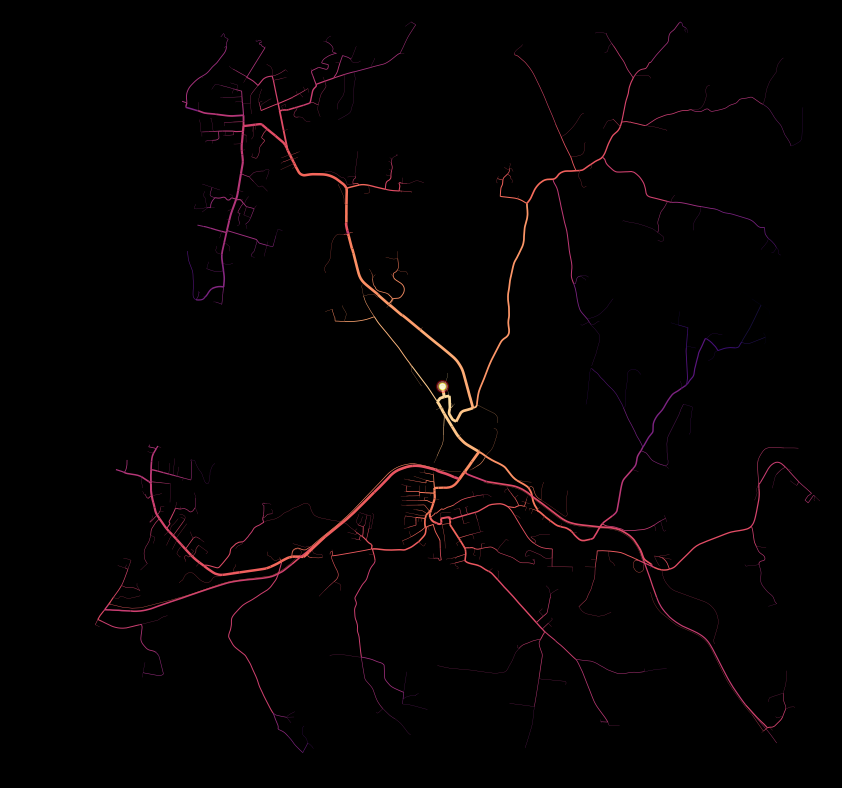

In [275]:
fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=0, 
                        save=True, fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')

ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='red', s=150, zorder=10, alpha=.25)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='pink', s=100, zorder=10, alpha=.3)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='yellow', s=50, zorder=10, alpha=.6)
ax.scatter([G.node[center_node]['x']], [G.node[center_node]['y']],
           color='white', s=30, zorder=10, alpha=.75)

# fig.savefig('nyc-bike.png', facecolor=fig.get_facecolor(), dpi=300)
fig.show()

# Can OSRM give us times?

In [164]:
origin_point

(40.7990123, -73.9680611)

In [231]:
end = '%s,%s' % (origin_point[1],origin_point[0])
starts = ['%s,%s' % (data['lon'],data['lat']) for n,data in G.node(data=True)]
starts = ';'.join(starts[0:350])
query = 'http://router.project-osrm.org/table/v1/driving/%s;%s?sources=0' % (end,starts)

In [232]:
% timeit r = requests.get(query)

508 ms ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [230]:
r.json()['durations'][0]

[0,
 208.2,
 186.3,
 158.7,
 110.9,
 75.1,
 120,
 175.7,
 500.2,
 452.7,
 386.2,
 517.1,
 471.8,
 864.7,
 906.7,
 949.8,
 978,
 477.5,
 420.1,
 382.1,
 319.1,
 483.1,
 421.1,
 1504.7,
 390.8,
 421.7,
 358.3,
 1891,
 1475,
 1736.8,
 1814,
 1698.1,
 1860.4,
 1707.5,
 916.6,
 742.5,
 742.9,
 690.8,
 648.2,
 384.2,
 349.3,
 414.9,
 248.6,
 289.9,
 347.9,
 1710.5,
 1846.3,
 1900.2,
 1937.2,
 1975.7,
 1903.1,
 1011.6,
 972.4,
 982,
 922.7,
 1089.9,
 1684.9,
 1590.2,
 438.5,
 485.9,
 1303.2,
 1116,
 594.9,
 455,
 1195.4,
 1283.8,
 1450.7,
 1357.7,
 1667.7,
 586.1,
 737,
 782,
 1245,
 1125.7,
 1062.8,
 1435.3,
 1449.5,
 1702.9,
 477.4,
 1348.4,
 1272.2,
 1328.7,
 1170.2,
 1366.2,
 1735.8,
 877.6,
 992.8,
 1272.6,
 1194.9,
 813.9,
 951,
 977.1,
 947.3,
 755.8,
 728.3,
 576.2,
 1249,
 1270.6,
 1117,
 1133,
 999.9,
 1036,
 931.7,
 514.2,
 592.4,
 888,
 2454.2,
 2467.8,
 2474,
 2476.6,
 1362.7,
 930.1,
 297.9,
 2303.6,
 878,
 866.5,
 1014.4,
 976.8,
 1077.2,
 1359.9,
 1229.9,
 1260.1,
 1463.4,
 12

# Plot 3D

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np

% matplotlib inline

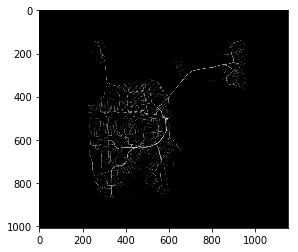

In [17]:
gray = np.mean(plt.imread('images/tavi.png'), -1)
plt.imshow(gray, cmap='gray')

In [18]:
r,c = gray.shape[:2]
X,Y = np.mgrid[0:r, 0:c]

In [19]:
from scipy.ndimage.filters import gaussian_filter

blurred = gaussian_filter(gray, sigma=4)

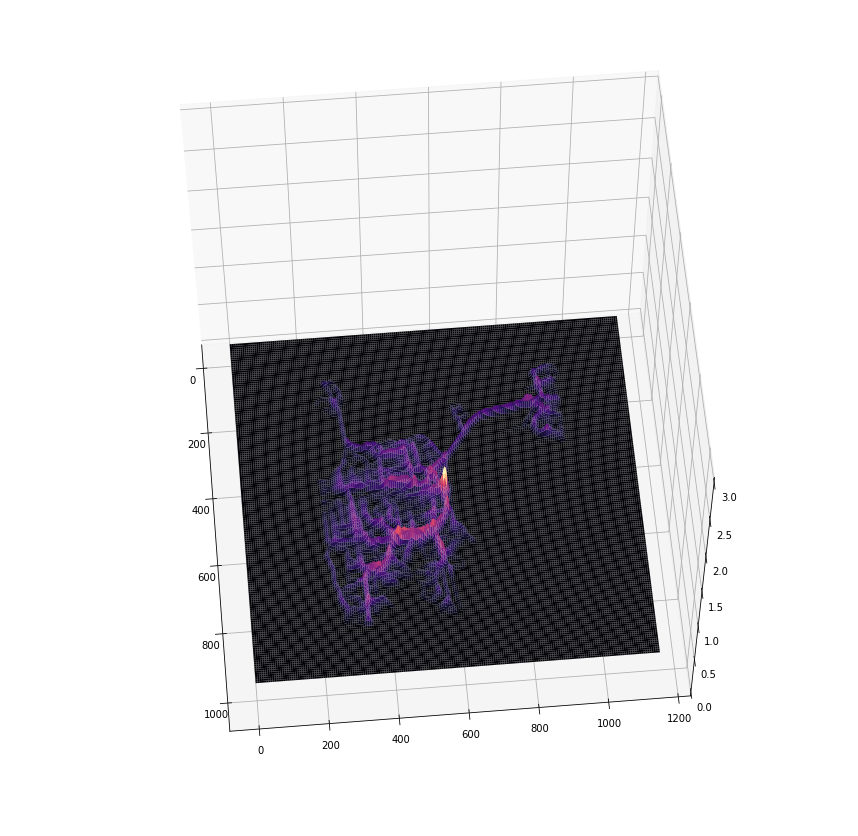

In [20]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, blurred, cmap=cm.get_cmap(name='magma'), rcount=200, ccount=200)
ax.set_zlim(0,3)
ax.view_init(elev=60, azim=-5)

# Things to try
- spatially uniform colormaps: such as inferno. done.
- logarithmic axes
    - switch to polar coordinates
- the map seems wrong, takes long detours? added "node penalty"
- map of PageRank?
- thin roads get drawn on top of fat roads

# Contour map, uses `transit_time`

In [34]:
max_x,max_y = -np.Inf,-np.Inf
min_x,min_y = np.Inf, np.Inf

for node,data in G.nodes(data=True):
    x = data['x']
    y = data['y']
    
    min_x = x if x<min_x else min_x
    min_y = y if y<min_y else min_y
    max_x = x if x>max_x else max_x
    max_y = y if y>max_y else max_y

X = np.arange(min_x, max_x, 200)
Y = np.arange(min_y, max_y, 200)

topo = np.ones(shape=(len(Y),len(X)))
topo_plus_feet = np.ones(shape=(len(Y),len(X)))

for j,x in enumerate(tqdm(X)):
    for i,y in enumerate(Y):
        nearest_node,distance = ox.get_nearest_node(G, (y,x), method='euclidean', return_dist=True)
        topo[i,j] = G.node[nearest_node]['transit_time'] if distance<200 else 0
        topo_plus_feet[i,j] = G.node[nearest_node]['transit_time'] + distance if distance<500 else 0

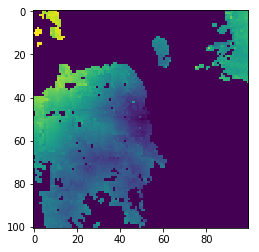

In [36]:
topo = np.flip(topo, 0)

plt.imshow(topo)

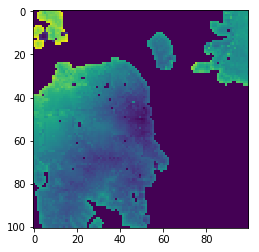

In [37]:
topo_plus_feet = np.flip(topo_plus_feet, 0)

plt.imshow(topo_plus_feet)

# interpolate

In [35]:
X = np.arange(min_x, max_x, 200)
Y = np.arange(min_y, max_y, 200)
X, Y = np.meshgrid(X, Y)

In [62]:
times = np.array([data['transit_time'] for node,data in G.nodes(data=True)])
points = np.array([(data['x'],data['y']) for node,data in G.nodes(data=True)])

In [81]:
from scipy.interpolate import griddata
Z = griddata(points, times, (X, Y), method='nearest')

In [ ]:
# plt.plot(points[:,0], points[:,1], '.')
plt.figure(figsize=(5,5))
plt.contour(X,Y,Z)

<a list of 12 text.Text objects>

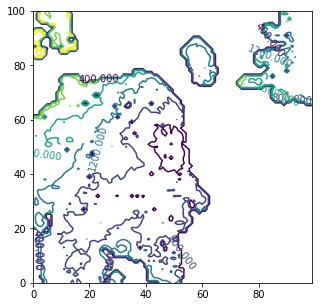

In [19]:
plt.figure(figsize=(5,5))
CS = plt.contour(topo_plus_feet)
plt.clabel(CS, inline=1, fontsize=10)

/Users/octavisemonin/anaconda3/envs/geo/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


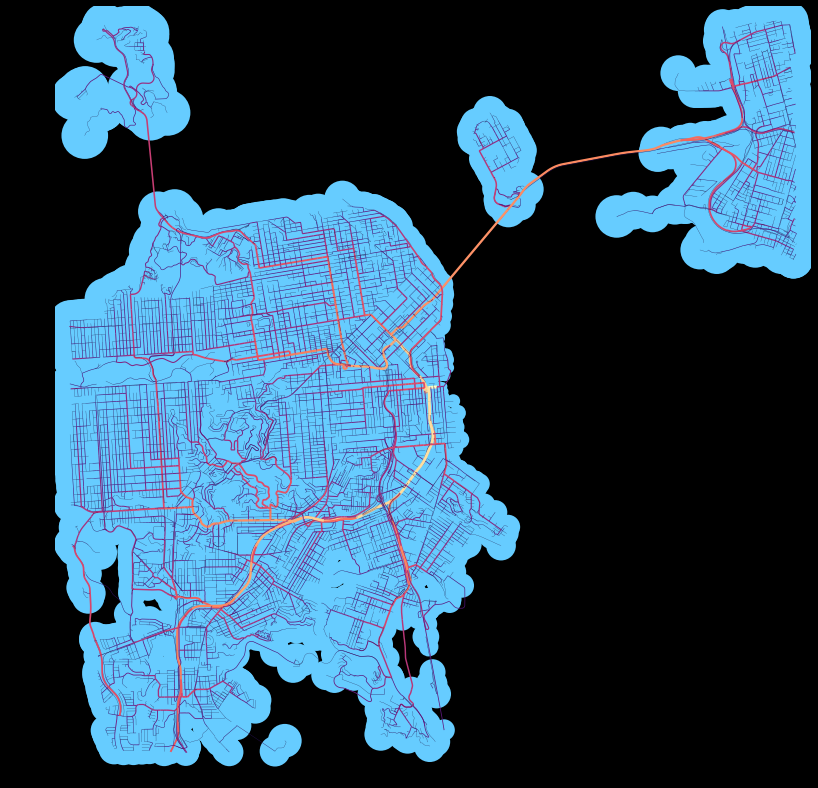

In [27]:
node_size = np.array([data['transit_time'] for n, data in G.nodes(data=True)])
fig, ax = ox.plot_graph(G, edge_color=edge_colors, edge_linewidth=edge_widths, equal_aspect=True, node_size=node_size, 
                        save=True, fig_height=14, fig_width=16, use_geom=True , close=False, show=False,  bgcolor='k')

# fig.savefig('test.png', facecolor=fig.get_facecolor(), dpi=300)
fig.show()